In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

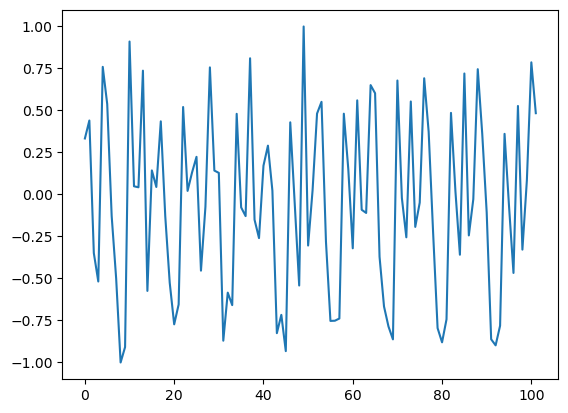

In [5]:
objetivo_train = 2*(objetivo_train-np.min(objetivo_train))/(np.max(objetivo_train)-np.min(objetivo_train)) - 1
conjunto_train = conjunto_train*(np.pi) + np.pi/2
plt.plot(objetivo_train)
plt.show()

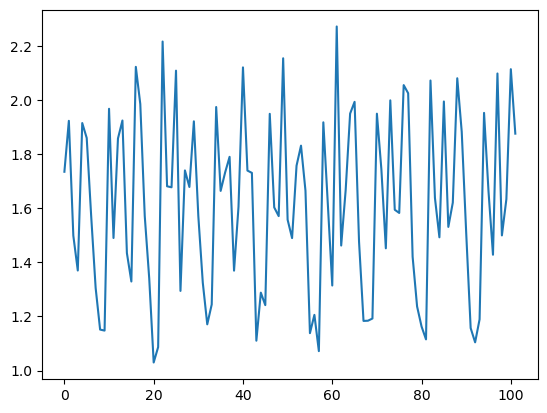

In [6]:
plt.plot(conjunto_train[:,0])
plt.show()

In [7]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
        
    for i in range(n_qubits-1):
        feature_map.cx(i,i+1)
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    
    ansatz = RealAmplitudes(n_qubits)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(QFT(n_qubits, inverse=True), inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [8]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [10]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [11]:
regressor = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error' ,
    optimizer=COBYLA(maxiter=1000),
    callback=callback_graph
)

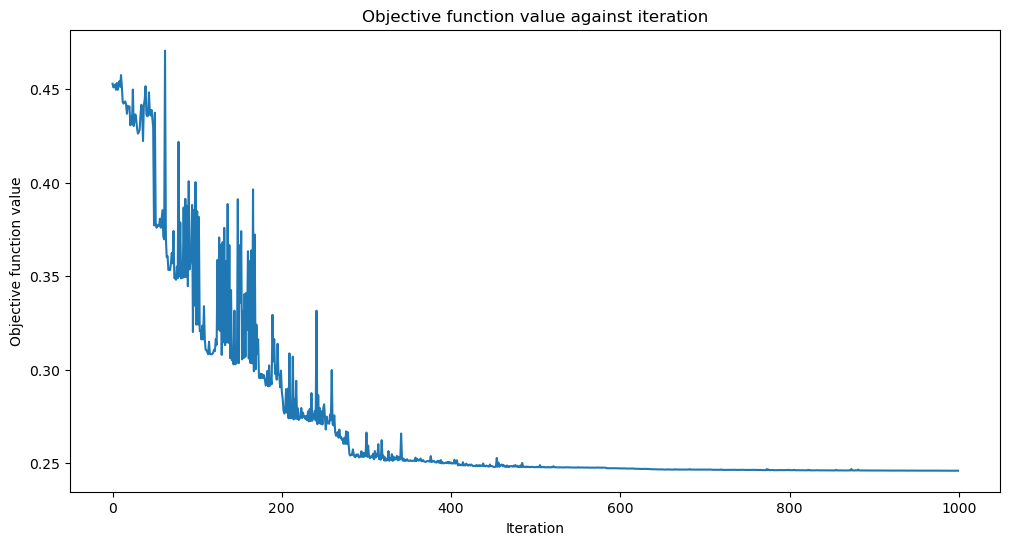

0.6611368605143787

In [12]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)
regressor.score(conjunto_train, objetivo_train)

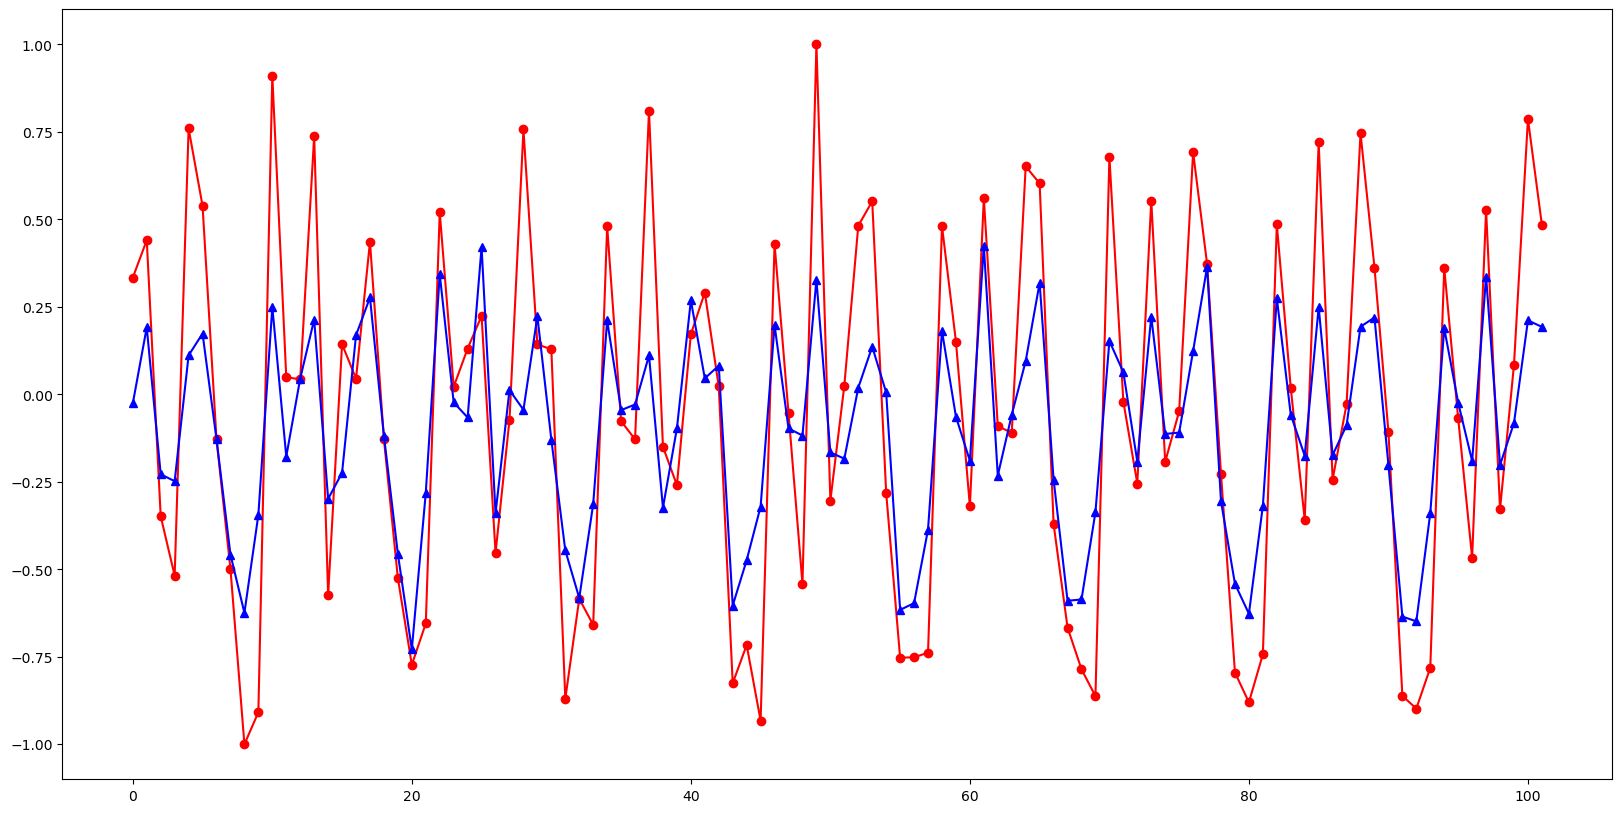

array([ 1.24679316,  1.12308004,  0.44116135,  1.59660673,  0.39080095,
        0.96609277,  0.38954472,  0.02150197,  1.63736769,  1.50459972,
        0.23745862,  3.1452139 ,  2.28708386,  0.01753584,  0.26397719,
        1.76390586, -0.15709661,  1.77165376,  1.32846712,  1.26339426,
        1.49073205,  0.19546463, -0.17256047,  0.10866027,  2.08652021,
        0.08224923,  1.23766767,  0.39996558,  1.03612288,  1.36305098,
        1.23678811,  0.92602397, -0.30742602, -0.55228198,  0.16947936,
        1.5675566 ,  0.01888755,  0.01021215, -0.01311268, -0.00732134,
       -0.0096288 , -0.01519359, -0.01145035, -0.02372123, -0.13500129,
        0.17890618,  0.08047569, -0.01960365])

In [13]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.weights

In [14]:
regressor2 = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error',
    optimizer=L_BFGS_B(maxiter=20),
    callback=callback_graph
)

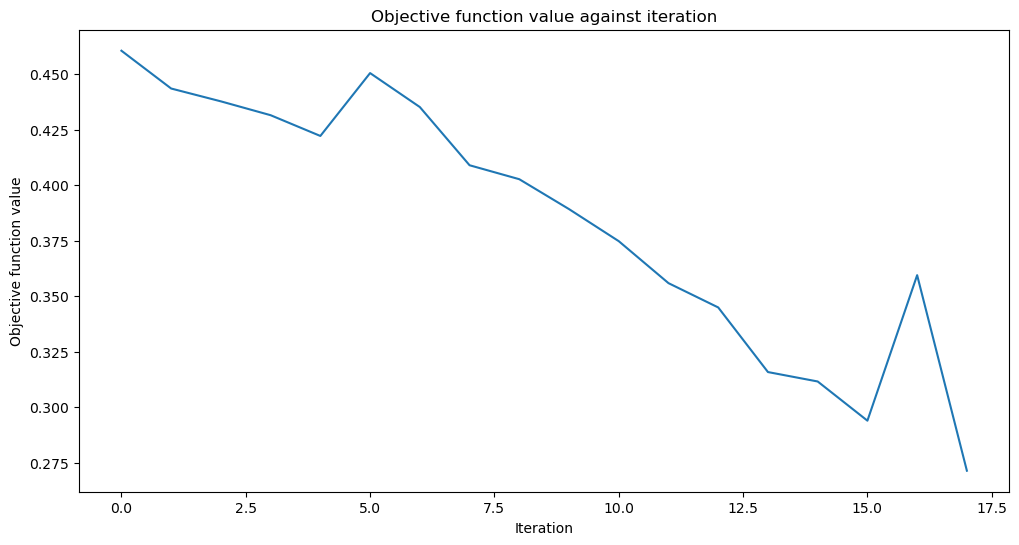

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor2.fit(conjunto_train, objetivo_train)
regressor2.score(conjunto_train, objetivo_train)

In [ ]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor2.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor2.weights

In [ ]:
vqr = VQR(
    feature_map=f1,
    ansatz=f2,
    optimizer=L_BFGS_B(maxiter=30),
    callback=callback_graph,
    loss='absolute_error' ,
)

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(conjunto_train, objetivo_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(conjunto_train, objetivo_train)

In [ ]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = vqr.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
vqr.weights